**Финальный проект**

Постановка задачи: провести кластеризацию на реальном датасете предприятия, содержащем параметры заказов. Попробать выявить границы и физический смысл обнаруженных кластеров, а также найти неочевидные сегменты заказов.


**1. Загрузка и анализ датасета**

In [1]:
# загрузка датасета
import pandas as pd

df = pd.read_csv('dataset.csv', sep=';', decimal=',')

--- Первые 5 строк ---
   Optic_TM    Th  Color  Lines  TO  TO_dens  Roll  NewGroup  NewCombo  Quant  \
0       1.0  20.0      8      2   1    11.02   360         0       0.0   7.71   
1       1.0  20.0      7      2   1    11.02   360         0       0.0   7.57   
2       1.0  20.0      8      2   1    11.02   360         0       0.0  10.48   
3       1.0  20.0      8      2   1    11.02   360         0       1.0  11.06   
4       1.0  20.0      8      2   1    11.02   360         0       0.0  17.46   

     Vs  Downtime  
0  3.06      0.00  
1  2.16      0.00  
2  4.20      0.00  
3  1.86      0.46  
4  4.56      0.26  
--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1776 entries, 0 to 1775
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Optic_TM  1776 non-null   float64
 1   Th        1776 non-null   float64
 2   Color     1776 non-null   int64  
 3   Lines     1776 non-null   int64  
 4   TO        1

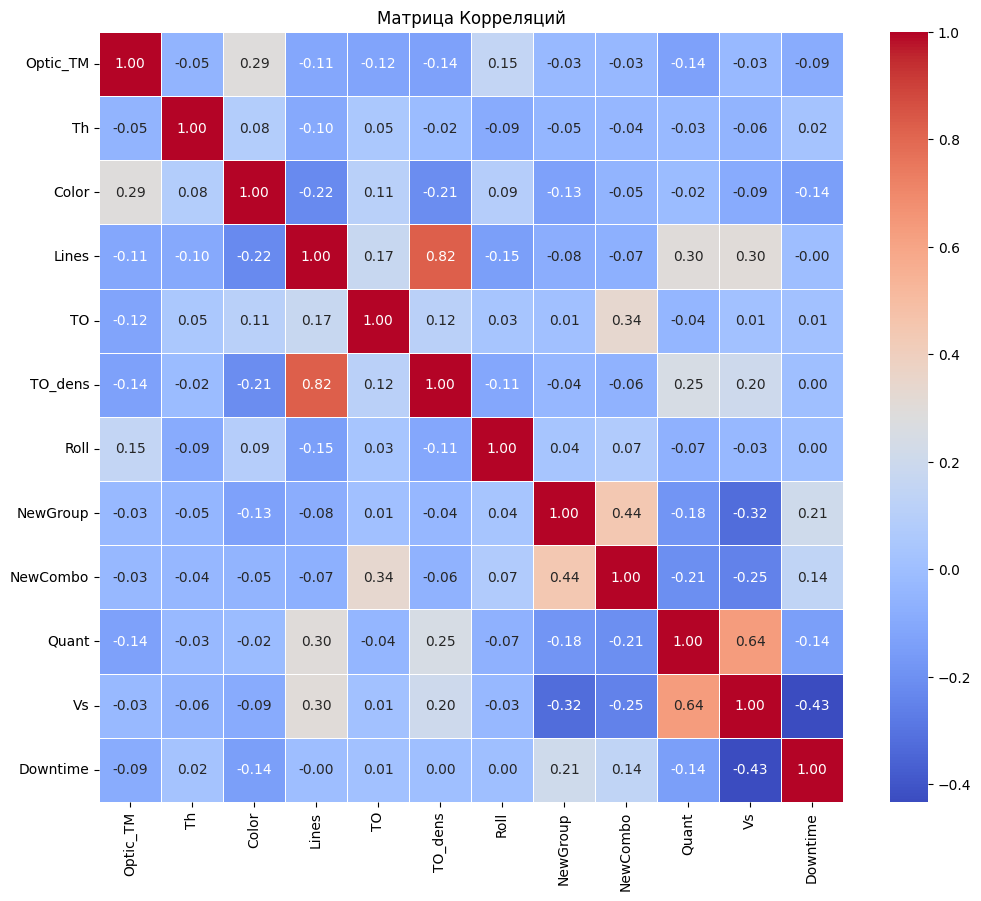

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Параметры:
# Optic_TM - свойство материала (1 - есть, 0/пусто - нет)
# Th - толщина
# Color - количество цветов
# Lines - количество линий
# TO - количество элементов
# TO_dens - плотность элементов
# Roll - параметр вращения
# NewGroup - есть новые элементы (1 - есть, 0/пусто - нет)
# NewCombo - новая комбинация (1 - да, 0/пусто - нет)
# Quant - количество
# Vs - скорость производства
# Downtime - время на технические донастройки (простои) в процессе выпуска

# заменим пустые значения на 0
df = df.fillna(0)

# анализ датасета
print('--- Первые 5 строк ---')
print(df.head())

print('--- Info ---')
print(df.info())

# матрица корреляций
correlation_matrix = df.corr()

# Визуализация матрицы корреляций с помощью Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Матрица Корреляций')
plt.show()

Видна коррелляция параметров TO_dens и Lines. Такая высокая корреляция не была очевидна. В дальнейшем исключим параметр Lines.

**2. Работа с размерностью методом PCA**


Доля объясненной дисперсии каждой компонентой:
[0.20974917 0.14835408 0.11613846 0.10536811 0.0812922  0.07730039
 0.07628789 0.06877902 0.05545165 0.03888095 0.02239807]

Кумулятивная объясненная дисперсия:
[0.20974917 0.35810326 0.47424172 0.57960983 0.66090203 0.73820242
 0.81449031 0.88326933 0.93872099 0.97760193 1.        ]


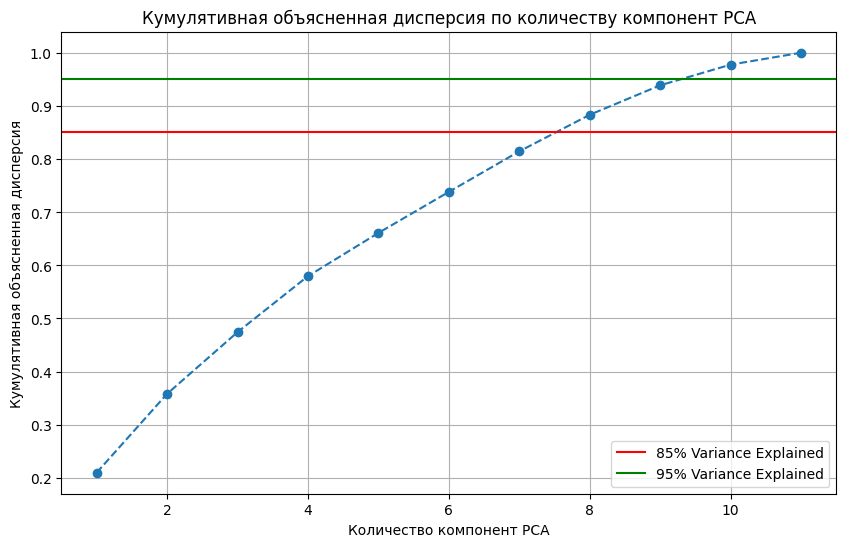

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop(['Lines'], axis=1))  # исключаем Lines

# Применяем PCA, изначально не указывая n_components, чтобы посмотреть дисперсию для всех компонент
pca_full = PCA(random_state=42)
pca_full.fit(X_scaled)

# Смотрим на объясненную дисперсию каждой компоненты
print("\nДоля объясненной дисперсии каждой компонентой:")
print(pca_full.explained_variance_ratio_)

# Смотрим на кумулятивную объясненную дисперсию
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
print("\nКумулятивная объясненная дисперсия:")
print(cumulative_variance)

# Строим график кумулятивной объясненной дисперсии
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Кумулятивная объясненная дисперсия по количеству компонент PCA')
plt.xlabel('Количество компонент PCA')
plt.ylabel('Кумулятивная объясненная дисперсия')
plt.grid(True)
# Добавляем горизонтальные линии для ориентира (например, 85% и 95%)
plt.axhline(y=0.85, color='r', linestyle='-', label='85% Variance Explained')
plt.axhline(y=0.95, color='g', linestyle='-', label='95% Variance Explained')
plt.legend()
plt.show()

Видим, что 8 компонент объясняют 90%.
Надо будет подумать над изначальным датасетом, провести расчеты с другими наборами параметров.

**3 Кластеризация**

3.1. K-Means

K=2: Силуэт = 0.2777; Калински-Харабаз = 672.3582
K=3: Силуэт = 0.3086; Калински-Харабаз = 786.8366
K=4: Силуэт = 0.3252; Калински-Харабаз = 849.7048
K=5: Силуэт = 0.2959; Калински-Харабаз = 788.6353
K=6: Силуэт = 0.2863; Калински-Харабаз = 759.9201
K=7: Силуэт = 0.2800; Калински-Харабаз = 725.9262
K=8: Силуэт = 0.2523; Калински-Харабаз = 666.0163
K=9: Силуэт = 0.2515; Калински-Харабаз = 640.1866


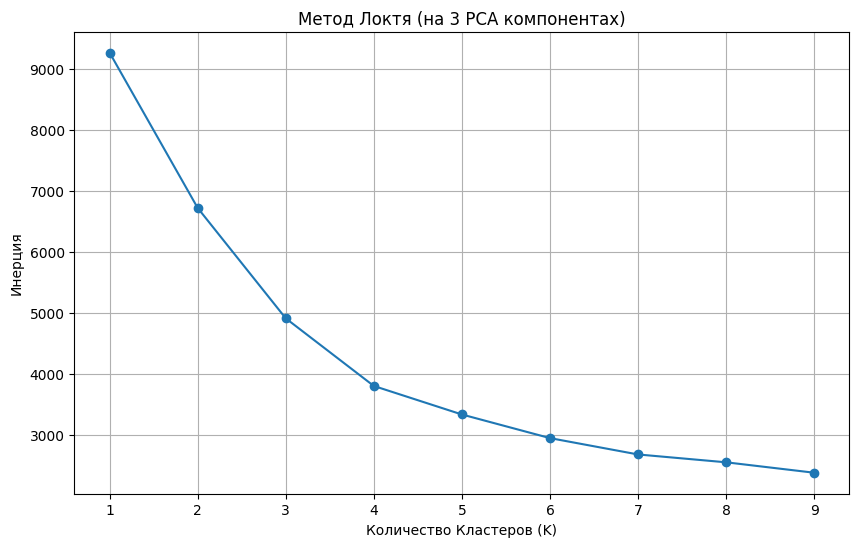

In [24]:
# в рамках текущего проекта поработаем с перыми тремя компонентами
n_components_chosen = 3

# Применяем PCA с выбранным количеством компонент и трансформируем данные
pca_3d = PCA(n_components=3, random_state=42)
X_pca_3d = pca_3d.fit_transform(X_scaled)

# --- Метод Локтя для K-Means (на PCA-данных) ---
k_range = range(1, 10) # Попробуем от 1 до 9 кластеров
inertia_values = []

for k in k_range:
    # Создаем и обучаем модель K-Means для текущего K
    # init='k-means++' - умный способ инициализации центров
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init='auto')
    kmeans.fit(X_pca_3d) # Обучаем на 3D PCA-данных
    inertia_values.append(kmeans.inertia_)

    # Рассчитываем силуэтный коэффициент для текущего K
    if k > 1:
        score_har = calinski_harabasz_score(X_pca_3d, kmeans.labels_)
        score_sil = silhouette_score(X_pca_3d, kmeans.labels_)
        print(f"K={k}: Силуэт={score_sil:.4f}; Калински-Харабаз={score_har:.4f}")

# Строим график метода локтя
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia_values, marker='o')
plt.title('Метод Локтя (на 3 PCA компонентах)')
plt.xlabel('Количество Кластеров (K)')
plt.ylabel('Инерция')
plt.xticks(k_range) # Показываем все значения K на оси x
plt.grid(True)
plt.show()

In [18]:
# лучшее K по методу локтя = 4-7, по метрикам 3-7
n_clusters_chosen = 4 # оптимально 4-5

# Применяем K-Means с выбранным K к данным после PCA
kmeans_final = KMeans(n_clusters=n_clusters_chosen, init='k-means++', random_state=42, n_init='auto')
kmeans_final.fit(X_pca_3d) # Обучаем на 3D PCA-данных

# Получаем метки кластеров для каждого объекта
cluster_labels = kmeans_final.labels_

# Добавляем метки кластеров обратно в исходный DataFrame для удобства интерпретации
df['Cluster'] = cluster_labels

# --- Визуализация Результатов Кластеризации в 3D ---
import plotly.express as px

# Подготовка данных для Plotly (нужен DataFrame)
df_plot = pd.DataFrame(X_pca_3d, columns=['PC1', 'PC2', 'PC3'])
df_plot['Cluster'] = cluster_labels # Добавляем числовые метки кластеров
# Преобразуем метки кластеров в строковый тип для Plotly
df_plot['Cluster_Str'] = df_plot['Cluster'].astype(str)

fig = px.scatter_3d(
    df_plot,
    x='PC1',
    y='PC2',
    z='PC3',
    color='Cluster_Str', # Используем строковые метки для дискретных цветов
    title=f'Результаты Кластеризации K-Means (K={n_clusters_chosen}) на Данных после PCA (3D) - Интерактивный',
    labels={'PC1': 'Компонента 1', 'PC2': 'Компонента 2', 'PC3': 'Компонента 3', 'Cluster_Str': 'Кластер'},
    # Настраиваем данные при наведении: показываем PC координаты и номер кластера
    hover_data={'PC1': ':.2f', 'PC2': ':.2f', 'PC3': ':.2f', 'Cluster': True, 'Cluster_Str': False}
)

fig.show()



Интерактивный график создан.


3.2. Агломеративная кластеризация


Запускаем Agglomerative Clustering с linkage='ward' для K от 2 до 9...
K=2: Силуэт=0.3853, Калински-Харабаз=525.0555
K=3: Силуэт=0.2780, Калински-Харабаз=670.5384
K=4: Силуэт=0.2840, Калински-Харабаз=653.0712
K=5: Силуэт=0.2446, Калински-Харабаз=646.3626
K=6: Силуэт=0.2413, Калински-Харабаз=621.0670
K=7: Силуэт=0.2416, Калински-Харабаз=607.2690
K=8: Силуэт=0.2361, Калински-Харабаз=582.5411
K=9: Силуэт=0.2429, Калински-Харабаз=572.7714


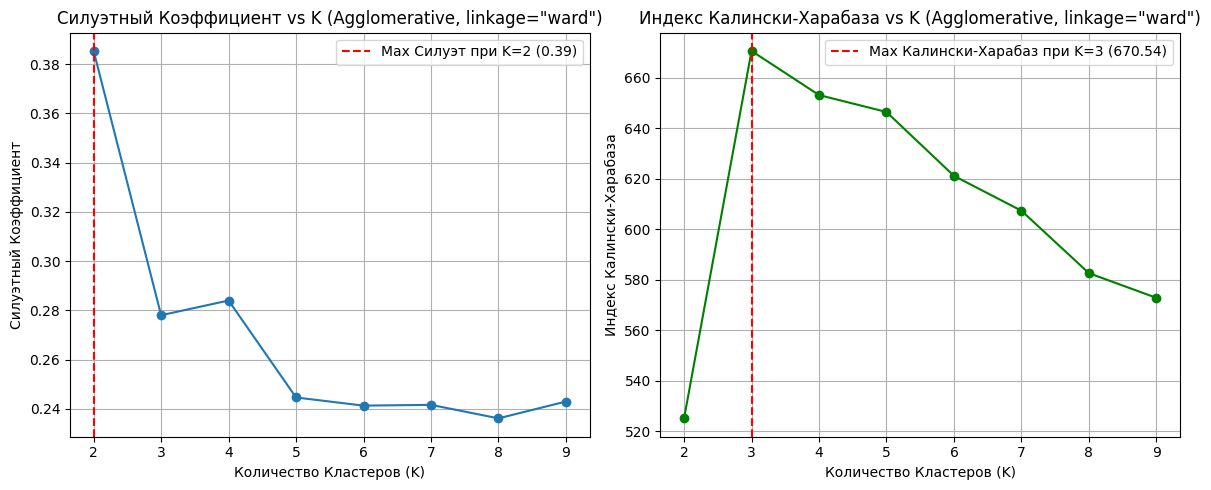

In [50]:
from sklearn.cluster import AgglomerativeClustering

# Поиск оптимального количества кластеров для Agglomerative Clustering
k_range = range(2, 10) # диапазон количества кластеров

# Используем один тип связи для анализа. Выберите один.
# linkage='ward' - требует metric='euclidean'
linkage_type_for_eval = 'ward' # варианты ('ward', 'complete', 'average')

# Списки для хранения значений метрик
silhouette_scores_agglo = []
calinski_harabasz_scores_agglo = []
evaluated_k_values = [] # Сохраним значения K, для которых рассчитаны метрики

print(f"\nЗапускаем Agglomerative Clustering с linkage='{linkage_type_for_eval}' для K от {min(k_range)} до {max(k_range)}...")

# --- Цикл для Запуска Кластеризации и Расчета Метрик для каждого K ---
for k in k_range:
    # Пропускаем K=1, так как метрики не определены
    if k == 1:
        continue

    # Создаем и обучаем модель Agglomerative Clustering
    agglo_model_eval = AgglomerativeClustering(
        n_clusters=k,
        linkage=linkage_type_for_eval,
        metric='euclidean'
    )
    agglo_cluster_labels_eval = agglo_model_eval.fit_predict(X_pca_3d) # Обучаем и получаем метки

    # Расчет Силуэтного Коэффициента
    silhouette_avg = silhouette_score(X_pca_3d, agglo_cluster_labels_eval)
    silhouette_scores_agglo.append(silhouette_avg)

    # Расчет Индекса Калински-Харабаза
    calinski_harabasz_index = calinski_harabasz_score(X_pca_3d, agglo_cluster_labels_eval)
    calinski_harabasz_scores_agglo.append(calinski_harabasz_index)

    evaluated_k_values.append(k) # Добавляем K в список

    print(f"K={k}: Силуэт={silhouette_avg:.4f}, Калински-Харабаз={calinski_harabasz_index:.4f}")

# График Силуэтного Коэффициента
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1) # Создаем область для первого графика
plt.plot(evaluated_k_values, silhouette_scores_agglo, marker='o')
plt.title(f'Силуэтный Коэффициент vs K (Agglomerative, linkage="{linkage_type_for_eval}")')
plt.xlabel('Количество Кластеров (K)')
plt.ylabel('Силуэтный Коэффициент')
plt.xticks(evaluated_k_values)
plt.grid(True)
# Опционально: Подсветить K с максимальным силуэтом
if len(evaluated_k_values) > 0 and not all(np.isnan(silhouette_scores_agglo)):
    # Ищем индекс максимального не-NaN значения
    max_index = np.nanargmax(silhouette_scores_agglo)
    best_k_silhouette = evaluated_k_values[max_index]
    max_silhouette = silhouette_scores_agglo[max_index]
    plt.axvline(x=best_k_silhouette, color='r', linestyle='--', label=f'Max Силуэт при K={best_k_silhouette:.0f} ({max_silhouette:.2f})')
    plt.legend()


# График Индекса Калински-Харабаза
plt.subplot(1, 2, 2) # Создаем область для второго графика
plt.plot(evaluated_k_values, calinski_harabasz_scores_agglo, marker='o', color='green')
plt.title(f'Индекс Калински-Харабаза vs K (Agglomerative, linkage="{linkage_type_for_eval}")')
plt.xlabel('Количество Кластеров (K)')
plt.ylabel('Индекс Калински-Харабаза')
plt.xticks(evaluated_k_values)
plt.grid(True)
 # Опционально: Подсветить K с максимальным индексом Калински-Харабаза
if len(evaluated_k_values) > 0 and not all(np.isnan(calinski_harabasz_scores_agglo)):
    # Ищем индекс максимального не-NaN значения
    max_index = np.nanargmax(calinski_harabasz_scores_agglo)
    best_k_ch = evaluated_k_values[max_index]
    max_ch = calinski_harabasz_scores_agglo[max_index]
    plt.axvline(x=best_k_ch, color='r', linestyle='--', label=f'Max Калински-Харабаз при K={best_k_ch:.0f} ({max_ch:.2f})')
    plt.legend()

plt.tight_layout()
plt.show()

In [51]:
# выбираем количество кластеров и обучаем модель
n_clusters_agglo = 4

agglo_final = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=0.8,
    linkage='average',
    metric='cosine'
)

agglo_cluster_labels = agglo_final.fit_predict(X_pca_3d)

# Подготовка данных для Plotly (нужен DataFrame)
df_plot_agglo = pd.DataFrame(X_pca_3d, columns=['PC1', 'PC2', 'PC3'])

# Используем метки кластеров
df_plot_agglo['Cluster_Agglo'] = agglo_cluster_labels

# Преобразуем метки в строковый тип для Plotly (для дискретных цветов)
df_plot_agglo['Cluster_Agglo_Str'] = df_plot_agglo['Cluster_Agglo'].astype(str)

fig_agglo = px.scatter_3d(
    df_plot_agglo, # DataFrame с данными
    x='PC1', # Колонка для оси X
    y='PC2', # Колонка для оси Y
    z='PC3', # Колонка для оси Z
    color='Cluster_Agglo_Str', # Колонка для раскрашивания точек по меткам
    title=f'Кластеризация Agglomerative (K={n_clusters_agglo}) на Данных после PCA (3D) - Интерактивный', # Заголовок
    labels={'PC1': 'Компонента 1', 'PC2': 'Компонента 2', 'PC3': 'Компонента 3', 'Cluster_Agglo_Str': 'Кластер'}, # Подписи осей и легенды
    hover_data={'PC1': ':.2f', 'PC2': ':.2f', 'PC3': ':.2f', 'Cluster_Agglo': True, 'Cluster_Agglo_Str': False} # Данные при наведении
)

fig_agglo.show()


Попробуем вместо подбора количества кластеров, подобрать параметр порога расстояния distance_threshold, чтобы модель сама определила кластера. Для этого сначала построим дендограмму и определим на каких "высотах" (расстояниях слияния) находятся разные уровни иерархии кластеров.


Построение дендрограммы...


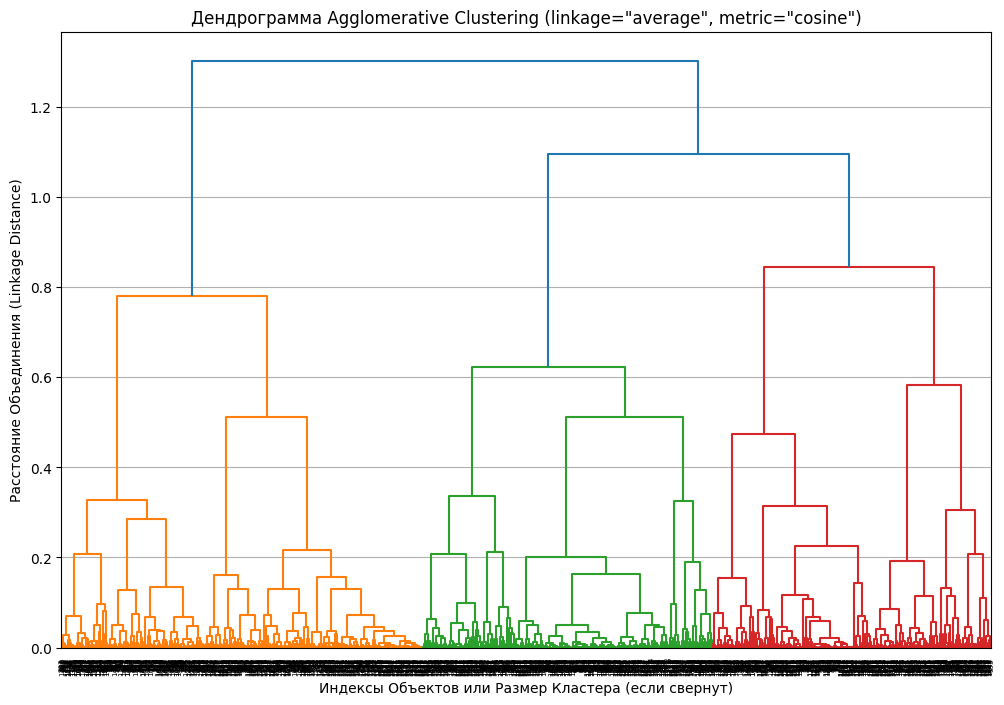

In [64]:
from scipy.cluster.hierarchy import dendrogram, linkage # Функции для иерархической кластеризации и дендрограммы

# путем предварительных экспериментов определены следующие параметры дендограммы
linkage_type_dendo = 'average' # ('ward', 'complete', 'average', 'single')
metric_type_dendo = 'cosine' # ('euclidean', 'cosine', etc. - совместимо с linkage)

# Вычисление Матрицы Связей
# Используем функцию linkage из Scipy на данных X_pca_3d
# Это основной шаг, который делает AgglomerativeClustering внутри для построения иерархии.
Z = linkage(X_pca_3d, method=linkage_type_dendo, metric=metric_type_dendo)

# Построение Дендрограммы
plt.figure(figsize=(12, 8))
# max_d - ограничивает количество отображаемых уровней/слияний для наглядности
# orientation - ориентация графика ('top', 'bottom', 'left', 'right')
dendro = dendrogram(
    Z,
    # truncate_mode='lastp', # Опционально: обрезать нижние уровни
    # p=10, # Опционально: показать только последние 10 объединений (верхние кластеры)
    orientation='top',
    # show_contracted=True, # Опционально: показать количество объединенных исходных точек
    # show_leaf_counts=True, # Опционально: показать количество точек в каждом конечном кластере на верхнем уровне
)
plt.title(f'Дендрограмма Agglomerative Clustering (linkage="{linkage_type_dendo}", metric="{metric_type_dendo}")')
plt.xlabel('Индексы Объектов или Размер Кластера (если свернут)')
plt.ylabel('Расстояние Объединения (Linkage Distance)')
plt.grid(axis='y')
plt.show()

In [68]:
# выбираем параметр distance_threshold и обучаем модель
distance_threshold=0.65

agglo_final = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=distance_threshold,
    linkage='average',
    metric='cosine'
)

agglo_cluster_labels = agglo_final.fit_predict(X_pca_3d)

# Подготовка данных для Plotly (нужен DataFrame)
df_plot_agglo = pd.DataFrame(X_pca_3d, columns=['PC1', 'PC2', 'PC3'])

# Используем метки кластеров
df_plot_agglo['Cluster_Agglo'] = agglo_cluster_labels

# Преобразуем метки в строковый тип для Plotly (для дискретных цветов)
df_plot_agglo['Cluster_Agglo_Str'] = df_plot_agglo['Cluster_Agglo'].astype(str)

fig_agglo = px.scatter_3d(
    df_plot_agglo, # DataFrame с данными
    x='PC1', # Колонка для оси X
    y='PC2', # Колонка для оси Y
    z='PC3', # Колонка для оси Z
    color='Cluster_Agglo_Str', # Колонка для раскрашивания точек по меткам
    title=f'Кластеризация Agglomerative (distance={distance_threshold}) на Данных после PCA (3D) - Интерактивный', # Заголовок
    labels={'PC1': 'Компонента 1', 'PC2': 'Компонента 2', 'PC3': 'Компонента 3', 'Cluster_Agglo_Str': 'Кластер'}, # Подписи осей и легенды
    hover_data={'PC1': ':.2f', 'PC2': ':.2f', 'PC3': ':.2f', 'Cluster_Agglo': True, 'Cluster_Agglo_Str': False} # Данные при наведении
)

fig_agglo.show()

3.3. Mean Shift

In [70]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Самый критичный шаг - выбор bandwidth.
# estimate_bandwidth может дать хорошую начальную оценку.
# Параметр quantile определяет, какой квантиль расстояний до ближайших соседей использовать.
# Значения от 0.1 до 0.3 часто являются хорошей отправной точкой для quantile.
# n_jobs=-1 ускоряет расчет
estimated_bandwidth = estimate_bandwidth(X_pca_3d, quantile=0.2, n_jobs=-1)

print(f"Оценочное Bandwidth: {estimated_bandwidth:.4f}")

# варианты корректоровки bandwidth = estimated_bandwidth * 0.8, estimated_bandwidth * 1.2
ms_model = MeanShift(bandwidth=estimated_bandwidth * 0.8, cluster_all=True, n_jobs=-1) # cluster_all=True - каждый объект в кластере

# Обучаем модель и получаем метки кластеров
ms_cluster_labels = ms_model.fit_predict(X_pca_3d)

# Получаем количество найденных кластеров (Mean Shift определяет их сам)
n_clusters_ms = len(np.unique(ms_cluster_labels))
# Если cluster_all=False и есть выбросы (-1), это будет дополнительная "метка"
# Если cluster_all=True, все точки будут в кластерах >= 0

print(f"Количество найденных кластеров: {n_clusters_ms}")

# Добавляем метки кластеров в исходный DataFrame
df['Cluster_MeanShift'] = ms_cluster_labels

# Метрики
if n_clusters_ms > 1:
    # Расчет Силуэтного Коэффициента
    silhouette_ms = silhouette_score(X_pca_3d, ms_cluster_labels)

    # Расчет Индекса Калински-Харабаза
    calinski_harabasz_ms = calinski_harabasz_score(X_pca_3d, ms_cluster_labels)
    print(f"Силуэт: {silhouette_ms:.4f}; Калински-Харабаза: {calinski_harabasz_ms:.4f}")

# Подготовка данных для Plotly (нужен DataFrame)
df_plot_ms = pd.DataFrame(X_pca_3d, columns=['PC1', 'PC2', 'PC3'])
df_plot_ms['Cluster_MeanShift'] = ms_cluster_labels

# Преобразуем метки в строковый тип для Plotly. Это также превратит метку -1 (если есть) в строку '-1'.
df_plot_ms['Cluster_MeanShift_Str'] = df_plot_ms['Cluster_MeanShift'].astype(str)

fig_ms = px.scatter_3d(
    df_plot_ms, # DataFrame с данными
    x='PC1', # Колонка для оси X
    y='PC2', # Колонка для оси Y
    z='PC3', # Колонка для оси Z
    color='Cluster_MeanShift_Str', # Колонка для раскрашивания точек по меткам
    title=f'Результаты Кластеризации Mean Shift (Найдено {n_clusters_ms} кластеров) на Данных после PCA (3D)',
    labels={'PC1': 'Компонента 1', 'PC2': 'Компонента 2', 'PC3': 'Компонента 3', 'Cluster_MeanShift_Str': 'Кластер'},
    hover_data={'PC1': ':.2f', 'PC2': ':.2f', 'PC3': ':.2f', 'Cluster_MeanShift': True, 'Cluster_MeanShift_Str': False}
)

fig_ms.show()

Оценочное Bandwidth: 1.9032
Количество найденных кластеров: 8
Силуэт: 0.2590; Калински-Харабаза: 306.6816


3.4. Affinity Propagation

In [89]:
from sklearn.cluster import AffinityPropagation

# damping: обычно 0.5 - 0.99. 0.5 по умолчанию.
damping_ap = 0.9 # (варианты 0.7, 0.9)

# preference: Самый важный параметр для контроля количества кластеров.
preference_ap = -80 # None (использует медиану) или вручную (например, -10, -50, -100...)

# Создаем и обучаем модель Affinity Propagation
ap_model = AffinityPropagation(damping=damping_ap, preference=preference_ap, affinity='euclidean')

# Обучаем модель и получаем метки кластеров
ap_cluster_labels = ap_model.fit_predict(X_pca_3d)

# Получаем количество найденных кластеров (Affinity Propagation определяет их сам)
n_clusters_ap = len(np.unique(ap_cluster_labels))

print(f"Количество найденных кластеров: {n_clusters_ap}")

# Добавляем метки кластеров в исходный DataFrame
df['Cluster_AffinityProp'] = ap_cluster_labels

# Метрики
if n_clusters_ap > 1:
    # Расчет Силуэтного Коэффициента
    silhouette_ap = silhouette_score(X_pca_3d, ap_cluster_labels)
    # Расчет Индекса Калински-Харабаза
    calinski_harabasz_ap = calinski_harabasz_score(X_pca_3d, ap_cluster_labels)
    print(f"Силуэт={silhouette_ap:.4f}; Калински-Харабаза={calinski_harabasz_ap:.4f}")

    print("Оценка метрик завершена.")
else:
    print("Метрики не определены или не применимы для одного кластера.")


# Визуализация, если найдено > 0 кластеров (технически может быть 0, хотя редко)
if n_clusters_ap > 0:
    # Подготовка данных для Plotly (нужен DataFrame)
    df_plot_ap = pd.DataFrame(X_pca_3d, columns=['PC1', 'PC2', 'PC3'])
    df_plot_ap['Cluster_AffinityProp'] = ap_cluster_labels

    # Преобразуем метки в строковый тип для Plotly
    df_plot_ap['Cluster_AffinityProp_Str'] = df_plot_ap['Cluster_AffinityProp'].astype(str)

    fig_ap = px.scatter_3d(
        df_plot_ap,
        x='PC1',
        y='PC2',
        z='PC3',
        color='Cluster_AffinityProp_Str',
        title=f'Результаты Кластеризации Affinity Propagation (Найдено {n_clusters_ap} кластеров) на Данных после PCA (3D)',
        labels={'PC1': 'Компонента 1', 'PC2': 'Компонента 2', 'PC3': 'Компонента 3', 'Cluster_AffinityProp_Str': 'Кластер'},
        hover_data={'PC1': ':.2f', 'PC2': ':.2f', 'PC3': ':.2f', 'Cluster_AffinityProp': True, 'Cluster_AffinityProp_Str': False}
    )

    fig_ap.show()
else:
    print("\nНевозможно построить 3D график, так как алгоритм не нашел ни одного кластера.")


Количество найденных кластеров: 16
Силуэт=0.2648; Калински-Харабаза=592.0721
Оценка метрик завершена.


3.5. DBSCAN

Расчет расстояний до 5-го ближайшего соседа для подсказки по eps...


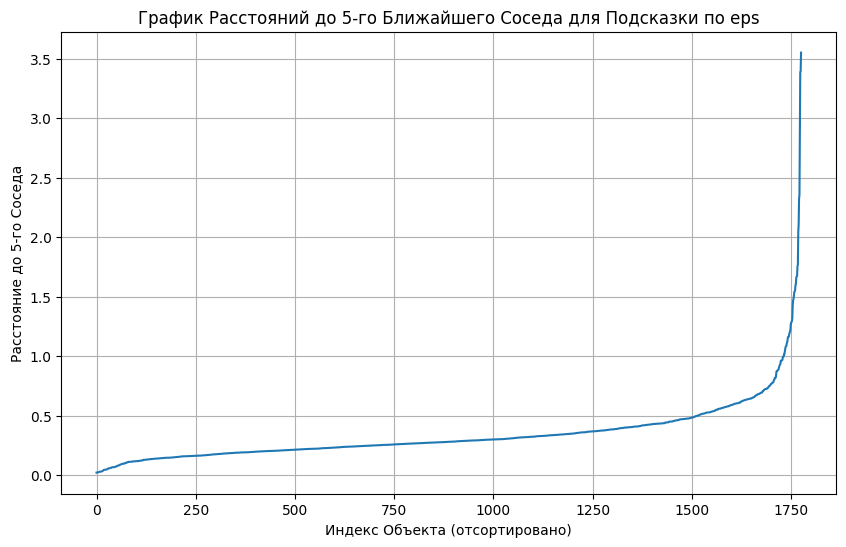

Значение расстояния на оси Y=0.6 в точке излома - кандидат для параметра 'eps'.

Применяем DBSCAN с eps=0.6000, min_samples=5...
Количество найденных кластеров (исключая шум): 7
Количество точек шума/выбросов (метка -1): 96
Найденные уникальные метки кластеров:
 [-1  0  1  2  3  4  5  6]
Силуэт: 0.2034; Калински-Харабаза: 56.8835


In [94]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors # Для графика k-расстояний

# Шаг 1: Выбрать значение для min_samples (например, 5 или 10)
min_samples_for_eps_plot = 5

# Шаг 2: Рассчитать расстояния до k-го ближайшего соседа (k = min_samples)
print(f"Расчет расстояний до {min_samples_for_eps_plot}-го ближайшего соседа для подсказки по eps...")
neigh = NearestNeighbors(n_neighbors=min_samples_for_eps_plot)
neigh.fit(X_pca_3d)
# distances - массив расстояний до каждого из n_neighbors соседей для каждой точки
distances, indices = neigh.kneighbors(X_pca_3d)

# Шаг 3: Отсортировать расстояния до k-го соседа (столбец min_samples_for_eps_plot-1, т.к. индексы с 0)
# distances[:, min_samples_for_eps_plot-1] - это расстояния до k-го соседа
sorted_distances = np.sort(distances[:, min_samples_for_eps_plot-1])

# Шаг 4: График
plt.figure(figsize=(10, 6))
plt.plot(sorted_distances)
plt.title(f'График Расстояний до {min_samples_for_eps_plot}-го Ближайшего Соседа для Подсказки по eps')
plt.xlabel('Индекс Объекта (отсортировано)')
plt.ylabel(f'Расстояние до {min_samples_for_eps_plot}-го Соседа')
plt.grid(True)
plt.show()

print("Значение расстояния на оси Y=0.6 в точке излома - кандидат для параметра 'eps'.")

# Параметры DBSCAN
eps_value = 0.6
min_samples_value = min_samples_for_eps_plot

print(f"\nПрименяем DBSCAN с eps={eps_value:.4f}, min_samples={min_samples_value}...")

# Создаем и обучаем модель DBSCAN
dbscan_model = DBSCAN(eps=eps_value, min_samples=min_samples_value, metric='euclidean')

# Обучаем модель и получаем метки кластеров
# Метка -1 означает шум/выбросы
dbscan_cluster_labels = dbscan_model.fit_predict(X_pca_3d)

# Получаем количество найденных уникальных меток (включая -1 для шума)
unique_labels = np.unique(dbscan_cluster_labels)
n_clusters_dbscan = len(unique_labels) - (1 if -1 in unique_labels else 0) # Количество кластеров (исключая шум)

print(f"Количество найденных кластеров (исключая шум): {n_clusters_dbscan}")
print(f"Количество точек шума/выбросов (метка -1): {(dbscan_cluster_labels == -1).sum()}")
print(f"Найденные уникальные метки кластеров:\n {unique_labels}")

# Добавляем метки кластеров в исходный DataFrame
df['Cluster_DBSCAN'] = dbscan_cluster_labels

# Метрики Силуэта и Калински-Харабаза (автоматически игнорируют точки с меткой -1)
if n_clusters_dbscan > 1:
    # Расчет Силуэтного Коэффициента
    silhouette_dbscan = silhouette_score(X_pca_3d, dbscan_cluster_labels)
    # Расчет Индекса Калински-Харабаза
    calinski_harabasz_dbscan = calinski_harabasz_score(X_pca_3d, dbscan_cluster_labels)

    print(f"Силуэт: {silhouette_dbscan:.4f}; Калински-Харабаза: {calinski_harabasz_dbscan:.4f}")

elif n_clusters_dbscan == 1:
     print("Найден только один кластер (исключая шум). Метрики Силуэта и Калински-Харабаза не применимы.")
else: # n_clusters_dbscan == 0 (все точки - шум)
    print("Не найдено ни одного кластера (все точки отнесены к шуму). Метрики не применимы.")

# Визуализируем только если есть хоть какие-то метки кластеров (не все -1)
if len(unique_labels) > 1 or (len(unique_labels) == 1 and -1 not in unique_labels):
    # Подготовка данных для Plotly (нужен DataFrame)
    df_plot_dbscan = pd.DataFrame(X_pca_3d, columns=['PC1', 'PC2', 'PC3'])
    df_plot_dbscan['Cluster_DBSCAN'] = dbscan_cluster_labels

    # Преобразуем метки в строковый тип для Plotly. Метка -1 станет строкой '-1'.
    df_plot_dbscan['Cluster_DBSCAN_Str'] = df_plot_dbscan['Cluster_DBSCAN'].astype(str)

    # Определяем заголовок с количеством кластеров и шума
    plot_title = f'Результаты Кластеризации DBSCAN (Кластеров: {n_clusters_dbscan}, Шум: {(dbscan_cluster_labels == -1).sum()}) на Данных после PCA (3D)'

    fig_dbscan = px.scatter_3d(
        df_plot_dbscan,
        x='PC1',
        y='PC2',
        z='PC3',
        color='Cluster_DBSCAN_Str', # Раскрашиваем по строковым меткам (включая '-1')
        title=plot_title,
        labels={'PC1': 'Главная Компонента 1', 'PC2': 'Главная Компонента 2', 'PC3': 'Главная Компонента 3', 'Cluster_DBSCAN_Str': 'Кластер'},
        hover_data={'PC1': ':.2f', 'PC2': ':.2f', 'PC3': ':.2f', 'Cluster_DBSCAN': True, 'Cluster_DBSCAN_Str': False}
    )

    fig_dbscan.show()
else:
    print("\nНевозможно построить 3D график: не найдено ни одного кластера, или все точки отнесены к шуму.")



**4. Аномалии**

На графике выше (DBSCAN) также указаны аномалии. Ниже рассмотрим другие модели поиска аномалий.

4.1. Isolation Forest

In [93]:
from sklearn.ensemble import IsolationForest

# поиск аномалий через Isolation Forest
model_if = IsolationForest(contamination=0.02, random_state=42) # допускаем до 2% аномалий

# Обучаем модель на масштабированных данных полной размерности (X_scaled)
model_if.fit(X_scaled)

# Получаем бинарное предсказание (-1 для аномалий, 1 для нормальных)
anomaly_predictions = model_if.predict(X_scaled)

# Получаем оценку аномальности (более низкое значение = более аномально)
anomaly_scores = model_if.decision_function(X_scaled)

# Добавляем предсказания и оценки аномальности обратно в исходный DataFrame
df['Anomaly_Prediction_IF'] = anomaly_predictions
df['Anomaly_Score_IF'] = anomaly_scores

print("\nРезультаты Isolation Forest добавлены в DataFrame ('Anomaly_Prediction_IF', 'Anomaly_Score_IF').")
print(f"Количество обнаруженных аномалий: {(df['Anomaly_Prediction_IF'] == -1).sum()}")

print("\nПостроение Интерактивного 3D Графика с раскраской по Аномалиям...")

# Подготовка данных для Plotly: используем X_pca_3d и добавляем колонки аномалий из df
df_plot_anomalies = pd.DataFrame(X_pca_3d, columns=['PC1', 'PC2', 'PC3'])

# Добавляем колонки с результатами Isolation Forest из df
# Убедимся, что индексы совпадают, т.к. мы работаем с преобразованными данными из df
df_plot_anomalies['Anomaly_Prediction_IF'] = df['Anomaly_Prediction_IF'].values
df_plot_anomalies['Anomaly_Score_IF'] = df['Anomaly_Score_IF'].values

df_plot_anomalies['Cluster'] = cluster_labels
df_plot_anomalies['Cluster_Str'] = df_plot_anomalies['Cluster'].astype(str)

print('--- Построение Интерактивного 3D Графика с раскраской по ПРЕДСКАЗАНИЮ аномалий ---')
# Раскрашиваем по бинарному предсказанию (-1 или 1)
fig_pred = px.scatter_3d(
    df_plot_anomalies,
    x='PC1',
    y='PC2',
    z='PC3',
    color='Anomaly_Prediction_IF', # Раскрашиваем по предсказанию аномалий (-1 или 1)
    title='Аномалии (Isolation Forest) на Данных PCA (3D) - Предсказание',
    labels={'PC1': 'Главная Компонента 1', 'PC2': 'Главная Компонента 2', 'PC3': 'Главная Компонента 3', 'Anomaly_Prediction_IF': 'Аномалия (-1) / Норма (1)'},
    hover_data={'PC1': ':.2f', 'PC2': ':.2f', 'PC3': ':.2f', 'Anomaly_Prediction_IF': True, 'Anomaly_Score_IF': ':.2f'} # Показываем предсказание и оценку при наведении
)
fig_pred.show()

print('--- Построение Интерактивного 3D Графика с раскраской по ОЦЕНКЕ аномальности ---')
# Раскрашиваем по непрерывной оценке аномальности
fig_score = px.scatter_3d(
    df_plot_anomalies,
    x='PC1',
    y='PC2',
    z='PC3',
    color='Anomaly_Score_IF', # Раскрашиваем по оценке аномальности (непрерывное значение)
    color_continuous_scale=px.colors.sequential.Viridis, # Цветовая шкала (можно выбрать другую)
    title='Аномалии (Isolation Forest) на Данных PCA (3D) - Оценка',
    labels={'PC1': 'Компонента 1', 'PC2': 'Компонента 2', 'PC3': 'Компонента 3', 'Anomaly_Score_IF': 'Оценка Аномальности'},
      hover_data={'PC1': ':.2f', 'PC2': ':.2f', 'PC3': ':.2f', 'Anomaly_Prediction_IF': True, 'Anomaly_Score_IF': ':.2f'} # Показываем предсказание и оценку при наведении
)
fig_score.show()


Результаты Isolation Forest добавлены в DataFrame ('Anomaly_Prediction_IF', 'Anomaly_Score_IF').
Количество обнаруженных аномалий: 36

Построение Интерактивного 3D Графика с раскраской по Аномалиям...
--- Построение Интерактивного 3D Графика с раскраской по ПРЕДСКАЗАНИЮ аномалий ---


--- Построение Интерактивного 3D Графика с раскраской по ОЦЕНКЕ аномальности ---
